ChEn-3170: Computational Methods in Chemical Engineering Spring 2023 UMass Lowell; Prof. V. F. de Almeida **23Mar23**

# 10. Shortest Least-Squares Solver
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\yvec}{\boldsymbol{\mathsf{y}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
* [Introduction](#intro)
* [Any Linear System (Detailed Algorithm)](#any)
* [Shortest LSQ Solver](#usolver)
* [Anomalous Least-Squares Data Fitting](#fit)
---

## [Introduction](#toc)<a id="intro"></a>

Recall course notes OneNote [ChEn-3170-shortest-lsq-solver](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EgTyfAiTr59Dk3yAb3eCZEcBeJZj2oWviJeXKpeRIB2YOg?e=aTnFnR) on computational stoichiometry including an introduction to the linear, rank-deficient, least-squares method.

Compute the solution vector $\xvec$ for a given matrix $\Amtrx$ and right-side vector $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

When $\Amtrx$ is rank deficient, $\Amtrx^\top\Amtrx$ is also rank deficient (or singular). The normal equations 

\begin{equation*}
\boxed{\Amtrx^\top\Amtrx\,\xvec_\text{LS}  = \Amtrx^\top\,\bvec },
\end{equation*}

*either have an infinite number of solutions or have no solution*. 

Since $\Amtrx$ is rank deficient, a **unique** mininum-norm least squares solution, $\xvec_\text{MNLS}$, exists as follows,

\begin{equation*}
 \lim\limits_{\epsilon\rightarrow 0}\,\min\limits_\xvec \bigl( \norm{\bvec - \Amtrx\,\xvec_\text{MNLS}}^2 + \epsilon\norm{\xvec_\text{MNLS}}^2 \bigr) \quad\  \forall \quad\ \xvec.
\end{equation*}

This solution is obtained by solving:

\begin{equation*}
\boxed{
\lim\limits_{\epsilon\rightarrow 0}\,\bigl(\Amtrx^\top\Amtrx + \epsilon\Imtrx\bigr) \xvec_\text{MNLS}  = \Amtrx^\top\,\bvec },
\end{equation*}

where $\Amtrx^\top\Amtrx + \epsilon\Imtrx$ is square, symmetric and full rank. This augmented least-squares problem has a unique solution.

## [Any Linear System (Detailed Algorithm)](#toc)<a id="any"></a>
Refer to course Notebooks 08 and 09.

In [1]:
'''Any A matrix'''

import numpy as np

nrows = 20
ncols = 32

a = -12.2
b =  88.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-8:] = 0.0
    if nrows < ncols:
        a_mtrx[-8:,:] = 0.0
        
np.set_printoptions(precision=3, threshold=500, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 67.577 -12.069  67.208  25.476 ...  55.968  83.339  15.192  35.18 ]
 [ -4.884  41.982  73.594  56.028 ...  26.102  -2.04   70.447  86.525]
 [ 32.39   87.991  19.259  77.82  ...  30.112  78.585  35.363  70.961]
 [ 66.947  72.326  51.788  -6.852 ...  13.124  38.198  52.233  41.889]
 ...
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]]


In [2]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (20, 32)
Rank of S =  12
Matrix is rank deficient.


In [3]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [ -2.173   0.423   0.213  -9.657 -37.126 -39.526  -3.29    2.227 -38.705 -36.116 -25.132 -21.205
   3.251  -2.196  -3.518  -8.05  -38.517 -37.857 -27.947  -4.655]


In [4]:
'''Compute the MNLS solution'''

import numpy as np

try:    
    from chen_3170.toolkit import solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

# build and solve A x = b MNLS problem

epsilon_values = np.logspace(+2,-6,5)

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)

x_norm_history = list()
    
for epsilon in epsilon_values:
    
    print('')
    print('epsilon = %1.1e'%epsilon)
    print('')

    mtrx = a_mtrx.transpose() @ a_mtrx + epsilon * np.eye(a_mtrx.shape[1]) # AT A + epsilon I, AT A is the normal matrix
    vec  = a_mtrx.transpose() @ b_vec                            # AT b

    # Solve (ATA + epsilon I) x = AT b
    x_vec = solve(mtrx, vec, pivot_tol=1e-9, zero_tol=1e-9) # matrix is full rank
    #x_vec = np.linalg.solve(mtrx, vec) # if my solver does not work
        
    x_norm = np.linalg.norm(x_vec)
    print('||x|| = %8.5e'%x_norm)
    
    x_norm_history.append( x_norm ) # save for plotting
    
    # test my solution against NumPy solve
    print('max(abs(x_vec-x_vec_numpy)) = %2.2e'%np.max(np.abs((x_vec - np.linalg.solve(mtrx, vec)))))
    
    print('')
    residual_vec = b_vec - a_mtrx @ x_vec
    print('||b - A x||^2 + eps*||x||^2 = %8.5e'%(np.linalg.norm(residual_vec)**2 + epsilon*x_norm**2))
    print('||b - A x|| +       ||x||   = %8.5e'%(np.linalg.norm(residual_vec) + x_norm))
    print('||b - A x||                 = %8.5e'%(np.linalg.norm(residual_vec)))


epsilon = 1.0e+02

||x|| = 4.29783e-01
max(abs(x_vec-x_vec_numpy)) = 1.31e-14

||b - A x||^2 + eps*||x||^2 = 3.83051e+03
||b - A x|| +       ||x||   = 6.21715e+01
||b - A x||                 = 6.17417e+01

epsilon = 1.0e+00

||x|| = 4.32300e-01
max(abs(x_vec-x_vec_numpy)) = 2.60e-12

||b - A x||^2 + eps*||x||^2 = 3.81212e+03
||b - A x|| +       ||x||   = 6.21731e+01
||b - A x||                 = 6.17408e+01

epsilon = 1.0e-02

||x|| = 4.32325e-01
max(abs(x_vec-x_vec_numpy)) = 1.55e-10

||b - A x||^2 + eps*||x||^2 = 3.81193e+03
||b - A x|| +       ||x||   = 6.21732e+01
||b - A x||                 = 6.17408e+01

epsilon = 1.0e-04

||x|| = 4.32325e-01
max(abs(x_vec-x_vec_numpy)) = 2.84e-08

||b - A x||^2 + eps*||x||^2 = 3.81193e+03
||b - A x|| +       ||x||   = 6.21732e+01
||b - A x||                 = 6.17408e+01

epsilon = 1.0e-06

||x|| = 4.32325e-01
max(abs(x_vec-x_vec_numpy)) = 2.49e-06

||b - A x||^2 + eps*||x||^2 = 3.81193e+03
||b - A x|| +       ||x||   = 6.21732e+01
||b - A x|| 

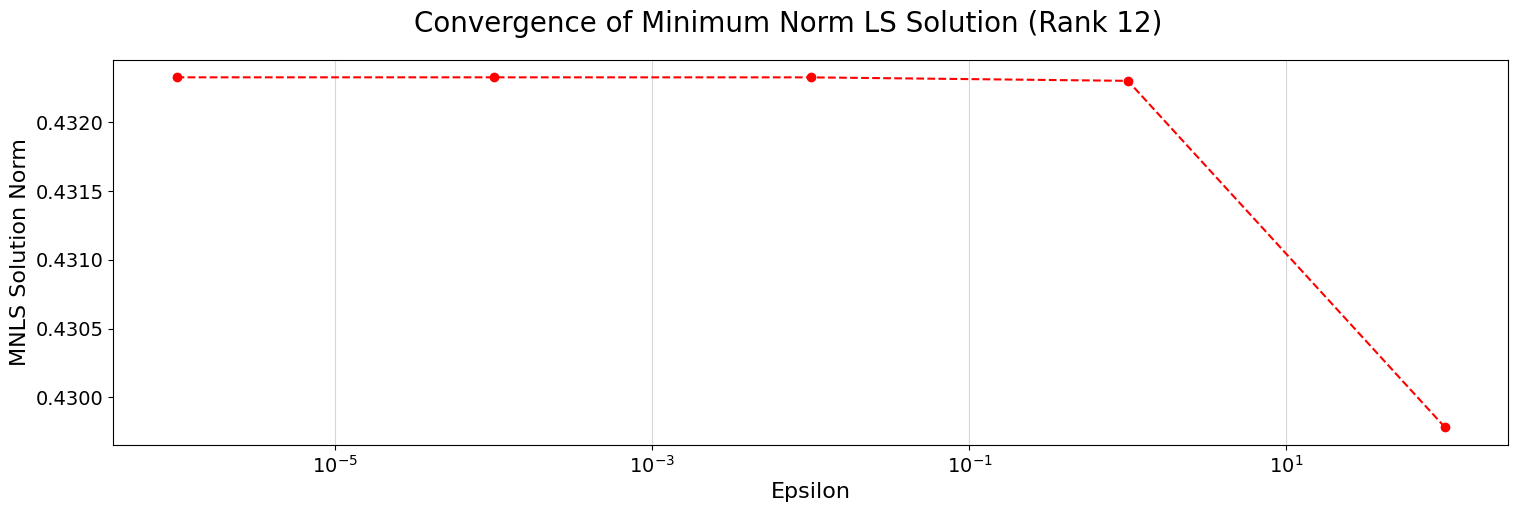

In [5]:
'''Plot Convergence of the Shortest Least-Square Solution Vector'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(18,5))
ax.semilogx(epsilon_values, x_norm_history,'ro--')
ax.set_ylabel('MNLS Solution Norm',fontsize=16)
ax.set_xlabel('Epsilon',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.suptitle('Convergence of Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
plt.show()

**NB:** Note that the associated rank-deficient LS problem, does not have a minimum. The computed $\xvec$ is the shortest LS solution of the modified (*regularized*) LS problem.

In [6]:
print('||AT(b - A x)|| = %8.5e'%(np.linalg.norm(a_mtrx.transpose()@residual_vec)))

||AT(b - A x)|| = 4.32326e-07


**NB:** For example take a non-zero vector, $\yvec$, from the null space of $\Amtrx$, *i.e.* $\Amtrx\yvec=\zerovec$. Note $\norm{\yvec}-\norm{\xvec} \ge 0$.

In [7]:
y0_vec = np.random.random(a_mtrx.shape[1])
y_vec = solve(a_mtrx, b_vec*0, y0_vec)
print('||y|| = %8.5e'%(np.linalg.norm(y_vec)))
print('||A y)|| = %8.5e'%(np.linalg.norm(a_mtrx@y_vec)))
print('||b - A y)|| = %8.5e'%(np.linalg.norm((b_vec-a_mtrx@y_vec))))
print('||y|| - ||x_MNLS|| = %8.5e'%(np.linalg.norm(y_vec)-np.linalg.norm(x_vec)))

||y|| = 6.91297e+00
||A y)|| = 3.16251e-13
||b - A y)|| = 1.03683e+02
||y|| - ||x_MNLS|| = 6.48064e+00


**NB:** More trials.

In [8]:
a = 2*x_vec.min()
b = 2*x_vec.max()

for i in range(10):
    y0_vec = (b-a)*np.random.random(ncols) + a
    y_vec = solve(a_mtrx, b_vec*0, y0_vec)
    print('||y|| = %8.5e'%(np.linalg.norm(y_vec)))
    print('||b - A y|| = %8.5e'%(np.linalg.norm((b_vec-a_mtrx@y_vec))))
    print('||y|| - ||x_MNLS|| = %8.5e'%(np.linalg.norm(y_vec)-np.linalg.norm(x_vec)))
    print('')

||y|| = 2.42679e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.99446e+00

||y|| = 1.55826e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.12594e+00

||y|| = 1.92038e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.48805e+00

||y|| = 1.72111e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.28878e+00

||y|| = 1.55438e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.12205e+00

||y|| = 2.23023e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.79790e+00

||y|| = 1.57689e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.14457e+00

||y|| = 2.34525e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.91293e+00

||y|| = 1.93905e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.50673e+00

||y|| = 1.59542e+00
||b - A y|| = 1.03683e+02
||y|| - ||x_MNLS|| = 1.16310e+00



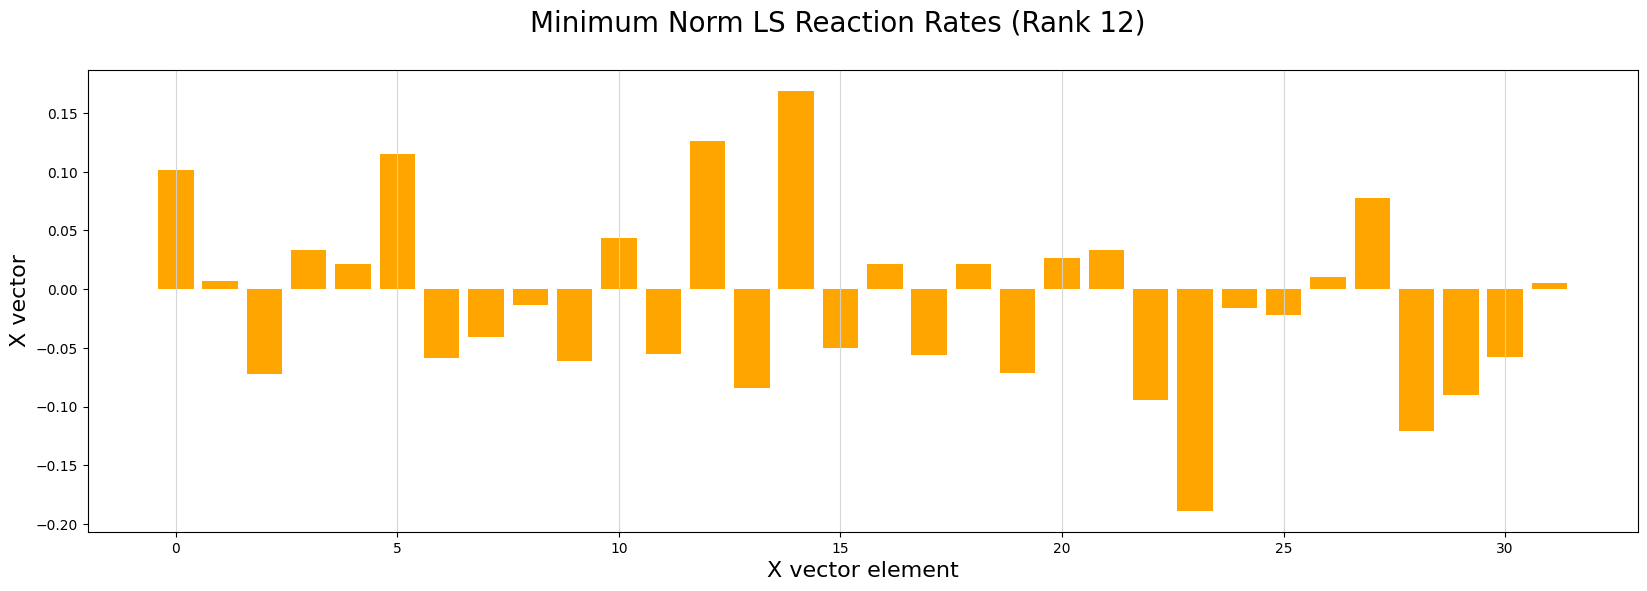

In [9]:
'''Minimum norm least-squares reaction rates'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Reaction Rates (Rank %s)'%str(a_rank),fontsize=20)
plt.show()

## [Shortest LSQ Solver](#toc)<a id="usolver"></a>

Compute the solution vector $\xvec$, given $\Amtrx$ and $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

In [10]:
'''Any A matrix'''

import numpy as np

nrows = 20
ncols = 32

a = -120.2
b =  808.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-1] = 0.0
    if nrows < ncols:
        a_mtrx[-1,:] = 0.0
        
np.set_printoptions(precision=3, threshold=100, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 792.116  337.3    -68.053  -87.134 ...  786.063  573.246  456.556  -62.084]
 [  42.07    93.886  217.774  370.213 ...  667.559  275.066   57.586   41.063]
 [ -71.255  297.464   17.416  113.591 ...  265.673  372.884  630.866  588.472]
 [ 764.643  -80.892  568.278  394.302 ...    5.396  702.521  397.38    17.927]
 ...
 [   1.626  186.129  776.233  242.902 ...  457.368  396.548  318.105  768.329]
 [ 268.526  716.349 -116.773  277.635 ...  -72.158  422.812  556.947  117.487]
 [   8.993  748.774 -108.072  299.527 ...  -96.975  553.025  279.446 -112.273]
 [   0.       0.       0.       0.    ...    0.       0.       0.       0.   ]]


In [11]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (20, 32)
Rank of S =  19
Matrix is rank deficient.


In [12]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [-10.169  -3.983 -16.486 -32.767 -20.585 -31.894  -8.4   -36.125 -10.027 -19.289 -40.192 -10.162
 -22.288 -36.063 -36.067 -19.662  -6.824  -7.499 -28.757 -39.094]


In [13]:
import numpy as np

try:    
    from chen_3170.toolkit import shortest_least_squares_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

x_vec = shortest_least_squares_solve(a_mtrx, b_vec, epsilon_min=-6, pivot_tol=1e-6)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of residual vector of the normal equations: ||AT(b - Ax)|| = %3.3e'%np.linalg.norm(a_mtrx.transpose()@(b_vec-a_mtrx@x_vec)))

Magnitude of residual vector: ||b - Ax|| = 3.909e+01
Magnitude of residual vector of the normal equations: ||AT(b - Ax)|| = 5.976e-08


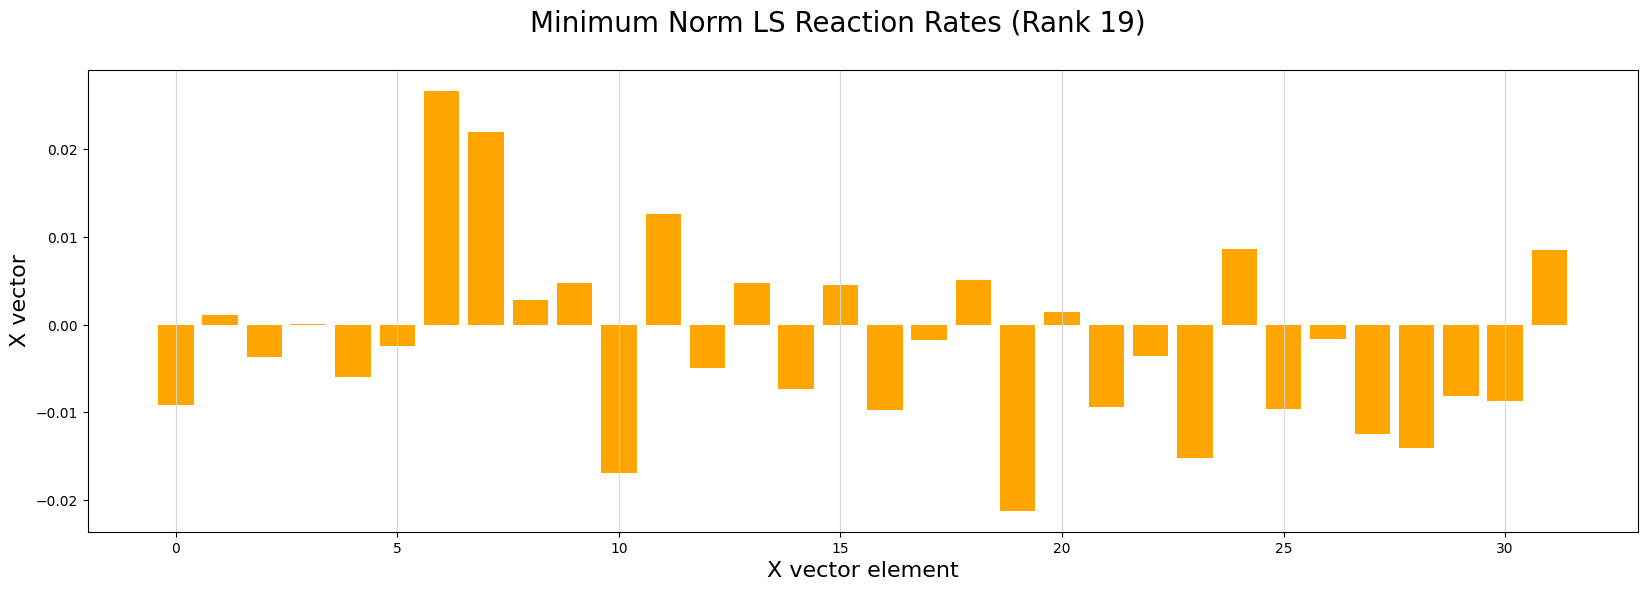

In [14]:
'''Minimum norm least-squares reaction rates'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Reaction Rates (Rank %s)'%str(a_rank),fontsize=20)
plt.show()

## [Anomalous Linear Least-Squares Data Fitting](#toc)<a id="fit"></a>

Example of data fitting where the universal solver is the only way to find a satisfactory fit.

In [ ]:
import numpy as np

m_pts = 7

x_values = 1*np.ones(m_pts)
y_values = 1.12 * abs(np.random.random(m_pts))

a_mtrx = np.zeros((m_pts, 2))
a_mtrx[:,0] = np.ones(m_pts)
a_mtrx[:,1] = -x_values


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
    
plt.figure(1, figsize=(7, 7))

plt.plot(x_values, y_values, 'r*', label='experimental')
    
plt.xlabel(r'$x$ []',fontsize=14)
plt.ylabel(r'$y$ []',fontsize=14)
plt.xlim(min(x_values)-.1, max(x_values)+.1)
plt.title('Some Arbitrary Data',fontsize=20)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

rank = matrix_rank(a_mtrx)

if rank == min(np.shape(a_mtrx)):
    print('Full-rank matrix')
else:
    print('Rank-deficient matrix')
print('matrix rank = ', rank)

In [ ]:
try:    
    from chen_3170.toolkit import universal_solve   
    from chen_3170.toolkit import solve  
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'
    
x_vec = universal_solve(a_mtrx, y_values, epsilon_min=-6, pivot_tol=1e-9)

#this will not work: x_vec = solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@y_values, pivot_tol=1e-7)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
    
plt.figure(1, figsize=(7, 7))

n_plot_pts = 15
x_plot = np.linspace(min(x_values)-.01, max(x_values)+.01, n_plot_pts)
a_mtrx_x = np.ones((n_plot_pts, 2))
a_mtrx_x[:,1]= -x_plot

plt.plot(x_values, y_values,'r*',label='experimental')
plt.plot(x_plot, a_mtrx_x@x_vec,'y*',label='MNLS')
    
plt.xlabel(r'$x$ []',fontsize=14)
plt.xlim(min(x_values)-.01, max(x_values)+.01)
plt.ylabel(r'$y$ []',fontsize=14)
plt.title('Linear Least-Squared Approximation',fontsize=20)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
y_values

In [ ]:
y_values.mean()

In [ ]:
a_mtrx_x@x_vec

In [ ]:
(a_mtrx_x@x_vec).mean()